In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
from datetime import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt

/Users/tjark/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_2854/2621361718.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://s

# Objective and approach of this notebook

In [3]:
# load maptis data and separate in number of trips on previous day and trips
# match types of trips with day profiles to create number of
# profiles linked to socio-economic profles

In [2]:
pwd

'/Users/tjark/Documents/Python/CairoPopulation.nosync/tfc-git/population'

In [3]:
#move working directory up to acces data with relative paths
os.chdir("..")

### Load data

In [4]:
# Read the GeoJSON file into a GeoDataFrame
god = gpd.read_file('data/raw/maptis/od_surveys/OD_surveys_cleaned_epsg_4326.geojson')
# Convert the GeoDataFrame to a regular pandas DataFrame
od = god.drop(columns='geometry')

# Read the GeoJSON file into a GeoDataFrame
gti = gpd.read_file('data/raw/maptis/ti_surveys/TI_surveys_cleaned_epsg_4326.geojson')
# Convert the GeoDataFrame to a regular pandas DataFrame
ti = gti.drop(columns='geometry')


In [5]:
len(god)

9739

In [6]:
len(gti)

2146

In [5]:
od.head(1)

,id,submitted_at,origin_x,origin_y,destination_x,destination_y,age,gender,income,occupation,...,transfers,transfers_no_walking,has_private_motorcycle,has_ride_hailing_account,has_metro_subscription_card,has_cta_subscription_card,has_none,has_private_car,has_bicycle,has_mm_subscription_card
0,6rjWwPcoWi-mEJL4pSmgH,2021-02-03 13:39:05.290000+00:00,31.324623,30.100202,31.246314,30.085274,26-35,female,4001-6000,working,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
ti.head(1)

,id,submitted_at,origin_x,origin_y,destination_x,destination_y,age,gender,income,trip_cost,...,rate_trip_comfort,rate_trip_duration,rate_trip_not_safe,rate_trip_transfers,rate_vehicle_not_safe,rate_trip_waiting_time,rate_trip_available_time,flag_cost,flag_trip_duration,flag_wait_walk_time
0,V-v3RrflsABmNaq1qtzeQ,2021-03-21 10:33:09.943000+00:00,31.333333,29.85,31.256141,29.963136,26-35,male,no_answer,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


### Calculate distance from coordinates

In [10]:
# Define a function to calculate the distance between two coordinates
def calculate_distance(row):
    origin = (row['origin_y'], row['origin_x'])
    destination = (row['destination_y'], row['destination_x'])
    return geodesic(origin, destination).kilometers

# Apply the calculate_distance function to each row of the DataFrame
od['distance'] = od.apply(calculate_distance, axis=1)
ti['distance'] = ti.apply(calculate_distance, axis=1)

### Filter by weekday/weekend in Egypt (Sunday-Thursday)

In [11]:
# Convert the 'submitted_at' column to datetime format
od['submitted_at'] = pd.to_datetime(od['submitted_at'])

# Extract the day of the week as a number (0 for Monday, 1 for Tuesday, and so on)
od['day_of_week'] = od['submitted_at'].dt.dayofweek

# Filter the DataFrame to include only Sunday, Monday, Tuesday, Wednesday, or Thursday
od_week = od[od['day_of_week'].isin([6, 0, 1, 2, 3])]

In [12]:
# Convert the 'submitted_at' column to datetime format
ti['submitted_at'] = pd.to_datetime(ti['submitted_at'])

# Extract the day of the week as a number (0 for Monday, 1 for Tuesday, and so on)
ti['day_of_week'] = ti['submitted_at'].dt.dayofweek

# Filter the DataFrame to include only Sunday, Monday, Tuesday, Wednesday, or Thursday
ti_week = ti[ti['day_of_week'].isin([6, 0, 1, 2, 3])]

In [13]:
# Convert the 'submitted_at' column to datetime format
ti['submitted_at'] = pd.to_datetime(ti['submitted_at'])

# Extract the day of the week as a number (0 for Monday, 1 for Tuesday, and so on)
ti['day_of_week'] = ti['submitted_at'].dt.dayofweek

# Filter the DataFrame to include only Monday, Tuesday, Wednesday, Thursday, and Friday for
# references to number of trips on previous day (weekday)
ti_week_prev = ti[ti['day_of_week'].isin([0, 1, 2, 3, 4])]

In [14]:
od_week.head(3)

,id,submitted_at,origin_x,origin_y,destination_x,destination_y,age,gender,income,occupation,...,has_private_motorcycle,has_ride_hailing_account,has_metro_subscription_card,has_cta_subscription_card,has_none,has_private_car,has_bicycle,has_mm_subscription_card,distance,day_of_week
0,6rjWwPcoWi-mEJL4pSmgH,2021-02-03 13:39:05.290000+00:00,31.324623,30.100202,31.246314,30.085274,26-35,female,4001-6000,working,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.727921,2
1,Mq5Gj8QIEciwWwc7LRsrF,2021-02-03 14:11:06.250000+00:00,31.152811,29.992433,31.201973,29.951972,36-45,male,no_answer,working,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.529161,2
2,WB9I66oaMQB8y7W92FrWl,2021-02-03 13:58:15.958000+00:00,31.322394,30.098643,31.240064,30.054885,18-25,female,no_answer,only_a_student,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.302396,2


In [15]:
ti_week.head(3)

,id,submitted_at,origin_x,origin_y,destination_x,destination_y,age,gender,income,trip_cost,...,rate_trip_not_safe,rate_trip_transfers,rate_vehicle_not_safe,rate_trip_waiting_time,rate_trip_available_time,flag_cost,flag_trip_duration,flag_wait_walk_time,distance,day_of_week
0,V-v3RrflsABmNaq1qtzeQ,2021-03-21 10:33:09.943000+00:00,31.333333,29.850000,31.256141,29.963136,26-35,male,no_answer,5.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,14.589661,6
1,hV6fpFrwiAUUMxXnYLxVo,2021-03-21 10:35:26.012000+00:00,31.213243,30.014782,31.273581,29.946330,36-45,male,4001-6000,12.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,9.564749,6
2,drcwYXoWCTYiEYZh9WqOf,2021-03-21 10:50:00.074000+00:00,31.247675,29.976166,31.263750,29.963951,26-35,male,6001-8000,5.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.059247,6


In [16]:
ti_week_prev.head(3)

,id,submitted_at,origin_x,origin_y,destination_x,destination_y,age,gender,income,trip_cost,...,rate_trip_not_safe,rate_trip_transfers,rate_vehicle_not_safe,rate_trip_waiting_time,rate_trip_available_time,flag_cost,flag_trip_duration,flag_wait_walk_time,distance,day_of_week
6,Ju6puL5UPvZbMEx0F_3mX,2021-03-22 09:52:45.052000+00:00,31.342205,30.052118,31.204258,30.010035,18-25,female,no_answer,5.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,14.099867,0
10,VU_EEwc3-0C-bQJ_YfNt6,2021-03-22 09:51:21.993000+00:00,31.221680,30.075123,31.249974,30.050991,56-65,male,2001-4000,7.5,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.820922,0
16,QUSsLdiNLh0BFlmSQt4mi,2021-03-22 06:51:28.190000+00:00,31.101015,29.081941,31.268411,29.987550,46-55,female,no_answer,20.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,101.684777,0


In [17]:
# Number of weekday entries for origin-destination
len(od_week)

9739

In [18]:
# Number of weekday entries for traveller interviews
len(ti_week)

2146

In [19]:
# Number of entries for traveller interviews where previous days are weekdays
len(ti_week_prev)

1665

In [ ]:
# Meaning of days
# 0 = Monday
# 1 = Tuesday
# 2 = Wednesday
# 3 = Thursday
# 4 = Friday
# 5 = Saturday
# 6 = Sunday

In [20]:
od_week['day_of_week'].value_counts()

2    2467
0    2390
1    1937
3    1593
6    1352
Name: day_of_week, dtype: int64

## Create traveller profiles based on each number of trips on previous day

In [21]:
# Filter all values with values of over 6 trips on previous day
ti_week_prev = ti_week_prev[ti_week_prev['trips_count'].isin(['0', '1', '2', '3', '4', '5', '6'])]

In [22]:
ti_week_prev['trips_count'].value_counts()

2    754
0    237
4    226
3    182
1    171
5     39
6     26
Name: trips_count, dtype: int64

In [23]:
# Filter nA values and keep 0 or 1 for vehicles
condition = ti_week_prev['vehicle_owned'].isin(['1', '2', '3', '4'])
new_values = np.where(condition, 1, ti_week_prev['vehicle_owned'])
ti_week_prev['vehicle_owned'] = new_values
ti_week_prev = ti_week_prev[ti_week_prev['vehicle_owned'].isin(['0',1])]
ti_week_prev['vehicle_owned'] = ti_week_prev['vehicle_owned'].astype(int)

In [24]:
ti_week_prev['vehicle_owned'].value_counts()

0    1089
1     543
Name: vehicle_owned, dtype: int64

In [25]:
ti_week_prev['age'].value_counts()

26-35    517
36-45    476
18-25    279
46-55    247
56-65     77
>18       24
66-75     11
<75        1
Name: age, dtype: int64

In [26]:
ti_week_prev['gender']

6       female
10        male
16      female
17      female
18        male
         ...  
2141    female
2142      male
2143      male
2144      male
2145      male
Name: gender, Length: 1632, dtype: object

In [27]:
# filter distances over 100 km to exclude trips outside of Cairo
ti_week_prev = ti_week_prev[ti_week_prev['distance'] <= 100]

In [28]:
base_profiles = ti_week_prev[['age','gender','vehicle_owned','trips_count']]

In [29]:
base_profiles.insert(0, 'profile_id', range(0, len(base_profiles)))
base_profiles.head(3)

,profile_id,age,gender,vehicle_owned,trips_count
6,0,18-25,female,0,0
10,1,56-65,male,0,2
17,2,18-25,female,0,3


## Merge all trip database

In [30]:
ti_week = ti_week[['age','gender','distance','trip_purpose']]

In [31]:
od_week = od_week[['age','gender','distance','trip_purpose']]

In [32]:
ti_week.head(1)

,age,gender,distance,trip_purpose
0,26-35,male,14.589661,personal


In [33]:
od_week.head(1)

,age,gender,distance,trip_purpose
0,26-35,female,7.727921,work


In [34]:
trips = pd.concat([od_week, ti_week])

In [35]:
trips.insert(0, 'id', range(0, len(trips)))

In [36]:
trips.head(3)

,id,age,gender,distance,trip_purpose
0,0,26-35,female,7.727921,work
1,1,36-45,male,6.529161,work
2,2,18-25,female,9.302396,personal


## Randomnly choose trips and assign to profiles

In [37]:
base_profiles['trips_count'].value_counts()

2    741
0    227
4    225
3    181
1    168
5     37
6     26
Name: trips_count, dtype: int64

### Minimum percentage of people staying at home

In [38]:
len(base_profiles[base_profiles['trips_count'] == '0']) / len(base_profiles)

0.14143302180685358

In [39]:
base_profiles.head()

,profile_id,age,gender,vehicle_owned,trips_count
6,0,18-25,female,0,0
10,1,56-65,male,0,2
17,2,18-25,female,0,3
18,3,26-35,male,0,2
19,4,36-45,male,0,2


In [108]:
base_profiles['trips_count'] = base_profiles['trips_count'].astype(int)
base_profiles['activities'] = 0  # Initialize 'activities' column with default value

# Set values based on 'trip_count'
base_profiles.loc[base_profiles['trips_count'] == 0, 'activities'] = 0
base_profiles.loc[base_profiles['trips_count'] == 1, 'activities'] = 1
base_profiles.loc[base_profiles['trips_count'] > 1, 'activities'] = base_profiles['trips_count'] - 1

/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_3497/1473799396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_profiles['trips_count'] = base_profiles['trips_count'].astype(int)
/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_3497/1473799396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_profiles['activities'] = 0  # Initialize 'activities' column with default value


In [143]:
base_profiles.to_csv('data/interim/activitychains/base_profiles.csv')

In [120]:
scaled_base_profiles = base_profiles.loc[base_profiles.index.repeat(base_profiles['activities'])]
# Create the 'activity_id' column
scaled_base_profiles['act_id'] = scaled_base_profiles.groupby(scaled_base_profiles.index).cumcount() + 1
# Reset the index of the scaled DataFrame
scaled_base_profiles = scaled_base_profiles.reset_index(drop=True)
scaled_base_profiles['act_id'] = scaled_base_profiles['profile_id'].astype(str) + '.' + scaled_base_profiles['act_id'].astype(str)

In [122]:
scaled_base_profiles.head(3)

,profile_id,age,gender,vehicle_owned,trips_count,activities,act_id
0,1,56-65,male,0,2,1,1.1
1,2,18-25,female,0,3,2,2.1
2,2,18-25,female,0,3,2,2.2


In [42]:
trips.head(3)

,id,age,gender,distance,trip_purpose
0,0,26-35,female,7.727921,work
1,1,36-45,male,6.529161,work
2,2,18-25,female,9.302396,personal


In [144]:
trips['trip_purpose'].value_counts()

work        4111
home        3361
personal    3313
edu          660
shopping     440
Name: trip_purpose, dtype: int64

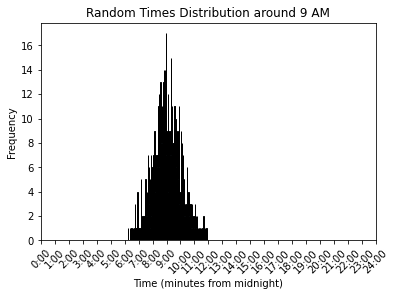

In [43]:
# Set the parameters
mean_minutes = 9 * 60  # 9 AM expressed in minutes from midnight
std_minutes = 60      # Standard deviation of 60 minutes
num_samples = 1000    # Number of random draws

# Generate random draws from a normal distribution
random_minutes = np.random.normal(mean_minutes, std_minutes, num_samples)

# Ensure the generated times are within the valid range (0 to 24*60)
random_minutes = np.clip(random_minutes, 0, 24 * 60)

# Convert minutes to hours and minutes format
random_hours = random_minutes // 60
random_mins = random_minutes % 60

# Visualize the distribution
bin_size = 6  # Bin size of 6 minutes
num_bins = int((24 * 60) / bin_size)

plt.hist(random_minutes, bins=num_bins, color='skyblue', edgecolor='black')
plt.xlabel('Time (minutes from midnight)')
plt.ylabel('Frequency')
plt.title('Random Times Distribution around 9 AM')
plt.xticks(range(0, 24*60+1, 60), ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00',
                                  '6:00', '7:00', '8:00', '9:00', '10:00', '11:00',
                                  '12:00', '13:00', '14:00', '15:00', '16:00', '17:00',
                                  '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '24:00'])
plt.xticks(rotation=45)
plt.show()

### One trip activity chains

In [44]:
one_trip = {0: [[10, 30], [11, 30]], 1: [[15, 30], [16, 30]]}

In [46]:
df = one_trip
df_fin = []

for x in range(len(one_trip)):
    df_chains = {}
    df_chains['start_1'] = np.round(np.random.normal(df[x][0][0] * 60, df[x][0][1], 1000))
    df_chains['end_1'] = np.round(np.random.normal(df[x][1][0] * 60, df[x][1][1], 1000))    
    df_chains = pd.DataFrame(df_chains)
    df_chains = df_chains[df_chains['start_1'] < df_chains['end_1']]
    df_chains = df_chains[(df_chains['start_1'] > 0) & (df_chains['start_1'] < 1440)]
    df_chains = df_chains[(df_chains['end_1'] > 0) & (df_chains['end_1'] < 1440)]
    df_fin.append(df_chains)

one_trip_chains = pd.concat(df_fin)

In [47]:
print(one_trip_chains.head(3))
print("___________________________________")
print("___________________________________")
one_trip_chains.info()

   start_1  end_1
0    655.0  684.0
1    643.0  679.0
2    597.0  627.0
___________________________________
___________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   start_1  1855 non-null   float64
 1   end_1    1855 non-null   float64
dtypes: float64(2)
memory usage: 43.5 KB


### Two trips activity chains

In [48]:
two_trip = {0: [[9, 60], [13, 60]], 1: [[15, 60], [19, 60]], 2: [[9, 60], [18, 60]]}

In [49]:
df = two_trip
df_fin = []

for x in range(len(df)):
    df_chains = {}
    df_chains['start_1'] = np.round(np.random.normal(df[x][0][0] * 60, df[x][0][1], 1000))
    df_chains['end_1'] = np.round(np.random.normal(df[x][1][0] * 60, df[x][1][1], 1000))    
    df_chains = pd.DataFrame(df_chains)
    df_chains = df_chains[df_chains['start_1'] < df_chains['end_1']]
    df_chains = df_chains[(df_chains['start_1'] > 0) & (df_chains['start_1'] < 1440)]
    df_chains = df_chains[(df_chains['end_1'] > 0) & (df_chains['end_1'] < 1440)]
    df_fin.append(df_chains)

two_trip_chains = pd.concat(df_fin)

In [50]:
print(two_trip_chains.head(3))
print("___________________________________")
print("___________________________________")
two_trip_chains.info()

   start_1  end_1
0    578.0  725.0
1    622.0  746.0
2    438.0  843.0
___________________________________
___________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2997 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   start_1  2997 non-null   float64
 1   end_1    2997 non-null   float64
dtypes: float64(2)
memory usage: 70.2 KB


### Three trips activity chains

In [51]:
three_trip = {0: [[[8, 60], [12, 60]], [[14, 60], [18, 60]]], 
              1: [[[8, 60], [15, 60]], [[17, 60], [19, 60]]],
              2: [[[9, 60], [11, 60]], [[13, 60], [20, 60]]],
              3: [[[8, 60], [12, 30]], [[13, 30], [15, 60]]],
              4: [[[13, 60], [15, 60]], [[18, 60], [20, 60]]]
            }

In [52]:
df = three_trip
df_fin = []

for x in range(len(df)):
    df_chains = {}
    for y in range(len(df[0])):
        df_chains[f'start_{y}'] = np.round(np.random.normal(df[x][y][0][0] * 60, 
                                                            df[x][y][0][1], 1000))
        df_chains[f'end_{y}'] = np.round(np.random.normal(df[x][y][1][0] * 60, 
                                                          df[x][y][0][1], 1000))    
        df_chains = pd.DataFrame(df_chains)

    # Validate internal trip relations
    df_chains = df_chains[df_chains[f'start_{y}'] < df_chains[f'end_{y}']]
    df_chains = df_chains[(df_chains[f'start_{y}'] > 0) & (df_chains[f'start_{y}'] < 1440)]
    df_chains = df_chains[(df_chains[f'end_{y}'] > 0) & (df_chains[f'end_{y}'] < 1440)]

    # Validate external trip relations (end time at least 15 min before start time of next act.)
    for y in range(len(df[0])-1):
        df_chains = df_chains[df_chains[f'end_{y}'] < (df_chains[f'start_{y+1}']-15)]
    
    df_fin.append(df_chains)

three_trip_chains = pd.concat(df_fin)

In [53]:
print(three_trip_chains.head(3))
print("___________________________________")
print("___________________________________")
three_trip_chains.info()

   start_0  end_0  start_1   end_1
1    438.0  671.0    822.0  1022.0
2    551.0  774.0    830.0  1042.0
3    399.0  603.0    740.0  1014.0
___________________________________
___________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4244 entries, 1 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   start_0  4244 non-null   float64
 1   end_0    4244 non-null   float64
 2   start_1  4244 non-null   float64
 3   end_1    4244 non-null   float64
dtypes: float64(4)
memory usage: 165.8 KB


### Four trips activity chains

In [54]:
four_trip = {0: [[[8, 60], [11, 30]], [[12, 30], [15, 30]], [[16, 30], [19, 60]]],
              1: [[[9, 60], [10, 30]], [[11, 30], [12, 30]], [[13, 30], [14, 60]]],
              2: [[[9, 60], [10, 30]], [[11, 30], [12, 30]], [[13, 30], [20, 60]]],
              3: [[[9, 60], [10, 30]], [[11, 30], [18, 30]], [[19, 30], [21, 60]]],
              4: [[[8, 60], [15, 30]], [[16, 30], [18, 30]], [[19, 30], [21, 60]]]
             }

In [55]:
df = four_trip
df_fin = []

for x in range(len(df)):
    df_chains = {}
    for y in range(len(df[0])):
        df_chains[f'start_{y}'] = np.round(np.random.normal(df[x][y][0][0] * 60, 
                                                            df[x][y][0][1], 1000))
        df_chains[f'end_{y}'] = np.round(np.random.normal(df[x][y][1][0] * 60, 
                                                          df[x][y][0][1], 1000))    
        df_chains = pd.DataFrame(df_chains)

    # Validate internal trip relations
    df_chains = df_chains[df_chains[f'start_{y}'] < df_chains[f'end_{y}']]
    df_chains = df_chains[(df_chains[f'start_{y}'] > 0) & (df_chains[f'start_{y}'] < 1440)]
    df_chains = df_chains[(df_chains[f'end_{y}'] > 0) & (df_chains[f'end_{y}'] < 1440)]

    # Validate external trip relations (end time at least 15 min before start time of next act.)
    for y in range(len(df[0])-1):
        df_chains = df_chains[df_chains[f'end_{y}'] < (df_chains[f'start_{y+1}']-15)]
    
    df_fin.append(df_chains)

four_trip_chains = pd.concat(df_fin)

In [56]:
print(four_trip_chains.head(3))
print("___________________________________")
print("___________________________________")
four_trip_chains.info()

   start_0  end_0  start_1  end_1  start_2   end_2
0    450.0  629.0    676.0  826.0    956.0  1131.0
1    527.0  622.0    725.0  897.0    920.0  1129.0
2    498.0  658.0    727.0  874.0    955.0  1142.0
___________________________________
___________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 0 to 998
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   start_0  3111 non-null   float64
 1   end_0    3111 non-null   float64
 2   start_1  3111 non-null   float64
 3   end_1    3111 non-null   float64
 4   start_2  3111 non-null   float64
 5   end_2    3111 non-null   float64
dtypes: float64(6)
memory usage: 170.1 KB


### Five trips activity chains

In [57]:
five_trip = {
0: [[[8, 60], [16, 30]], [[17, 30], [18, 30]], [[19, 30], [20, 30]], [[21, 30], [22, 30]]],
1: [[[8, 60], [12, 30]], [[13, 30], [15, 30]], [[16, 30], [19, 30]], [[20, 30], [21, 30]]],
2: [[[6, 60], [10, 30]], [[11, 30], [16, 30]], [[17, 30], [19, 30]], [[20, 30], [21, 30]]],
3: [[[9, 60], [14, 30]], [[15, 30], [19, 30]], [[20, 30], [21, 30]], [[22, 30], [23, 60]]],
4: [[[9, 30], [10, 30]], [[11, 30], [12, 30]], [[13, 30], [20, 60]], [[21, 30], [23, 30]]],
5: [[[9, 60], [17, 30]], [[18, 30], [19, 30]], [[20, 30], [21, 30]], [[22, 30], [23, 30]]],
6: [[[12, 30], [13, 30]], [[14, 30], [15, 30]], [[16, 30], [17, 30]], [[18, 30], [19, 30]]],
7: [[[11, 60], [13, 30]], [[17,30], [18, 30]], [[19, 30], [20, 30]], [[21, 30], [22, 30]]]
}

In [58]:
df = five_trip
df_fin = []

for x in range(len(df)):
    df_chains = {}
    for y in range(len(df[0])):
        df_chains[f'start_{y}'] = np.round(np.random.normal(df[x][y][0][0] * 60, 
                                                            df[x][y][0][1], 1000))
        df_chains[f'end_{y}'] = np.round(np.random.normal(df[x][y][1][0] * 60, 
                                                          df[x][y][0][1], 1000))    
        df_chains = pd.DataFrame(df_chains)

    # Validate internal trip relations
    df_chains = df_chains[df_chains[f'start_{y}'] < df_chains[f'end_{y}']]
    df_chains = df_chains[(df_chains[f'start_{y}'] > 0) & (df_chains[f'start_{y}'] < 1440)]
    df_chains = df_chains[(df_chains[f'end_{y}'] > 0) & (df_chains[f'end_{y}'] < 1440)]

    # Validate external trip relations (end time at least 15 min before start time of next act.)
    for y in range(len(df[0])-1):
        df_chains = df_chains[df_chains[f'end_{y}'] < (df_chains[f'start_{y+1}']-15)]
    
    df_fin.append(df_chains)

five_trip_chains = pd.concat(df_fin)

In [59]:
print(five_trip_chains.head(3))
print("___________________________________")
print("___________________________________")
five_trip_chains.info()

   start_0  end_0  start_1   end_1  start_2   end_2  start_3   end_3
0    454.0  896.0   1011.0  1086.0   1140.0  1228.0   1276.0  1334.0
1    379.0  980.0   1018.0  1059.0   1201.0  1188.0   1233.0  1252.0
2    428.0  940.0    971.0  1062.0   1120.0  1206.0   1241.0  1285.0
___________________________________
___________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 0 to 999
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   start_0  4225 non-null   float64
 1   end_0    4225 non-null   float64
 2   start_1  4225 non-null   float64
 3   end_1    4225 non-null   float64
 4   start_2  4225 non-null   float64
 5   end_2    4225 non-null   float64
 6   start_3  4225 non-null   float64
 7   end_3    4225 non-null   float64
dtypes: float64(8)
memory usage: 297.1 KB


### Six trips activity chains

In [60]:
six_trip = {
0: [[[7, 60], [15, 30]], [[16, 30], [17, 30]], [[18, 30], [19, 30]], [[20, 30], [21, 30]], [[22, 30], [23, 30]]],
1: [[[7, 60], [9, 30]], [[10, 30], [12, 30]], [[13, 30], [14, 30]], [[15, 30], [16, 30]], [[17, 30], [19, 60]]],
2: [[[8, 60], [15, 30]], [[16, 30], [17, 30]], [[18, 30], [19, 30]], [[20, 30], [21, 30]], [[22, 30], [23, 30]]],
3: [[[8, 30], [9, 30]], [[10, 30], [16, 30]], [[17, 30], [18, 30]], [[19, 30], [20, 30]], [[21, 30], [22, 30]]],
4: [[[9, 60], [15, 30]], [[16, 30], [17, 30]], [[18, 30], [19, 30]], [[20, 30], [21, 30]], [[22, 30], [23, 30]]],
5: [[[9, 30], [10, 30]], [[11, 30], [16, 30]], [[17, 30], [18, 30]], [[19, 30], [20, 30]], [[21, 30], [22, 30]]]
}

In [61]:
df = six_trip
df_fin = []

for x in range(len(df)):
    df_chains = {}
    for y in range(len(df[0])):
        df_chains[f'start_{y}'] = np.round(np.random.normal(df[x][y][0][0] * 60, 
                                                            df[x][y][0][1], 1000))
        df_chains[f'end_{y}'] = np.round(np.random.normal(df[x][y][1][0] * 60, 
                                                          df[x][y][0][1], 1000))    
        df_chains = pd.DataFrame(df_chains)

    # Validate internal trip relations
    df_chains = df_chains[df_chains[f'start_{y}'] < df_chains[f'end_{y}']]
    df_chains = df_chains[(df_chains[f'start_{y}'] > 0) & (df_chains[f'start_{y}'] < 1440)]
    df_chains = df_chains[(df_chains[f'end_{y}'] > 0) & (df_chains[f'end_{y}'] < 1440)]

    # Validate external trip relations (end time at least 15 min before start time of next act.)
    for y in range(len(df[0])-1):
        df_chains = df_chains[df_chains[f'end_{y}'] < (df_chains[f'start_{y+1}']-15)]
    
    df_fin.append(df_chains)

six_trip_chains = pd.concat(df_fin)

In [62]:
print(six_trip_chains.head(3))
print("___________________________________")
print("___________________________________")
six_trip_chains.info()

   start_0  end_0  start_1   end_1  start_2   end_2  start_3   end_3  start_4  \
0    469.0  861.0    918.0  1085.0   1120.0  1198.0   1221.0  1232.0   1320.0   
1    294.0  928.0   1053.0  1023.0   1054.0  1091.0   1219.0  1235.0   1294.0   
2    463.0  852.0    979.0  1036.0   1093.0  1153.0   1265.0  1264.0   1295.0   

    end_4  
0  1406.0  
1  1373.0  
2  1372.0  
___________________________________
___________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2640 entries, 0 to 997
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   start_0  2640 non-null   float64
 1   end_0    2640 non-null   float64
 2   start_1  2640 non-null   float64
 3   end_1    2640 non-null   float64
 4   start_2  2640 non-null   float64
 5   end_2    2640 non-null   float64
 6   start_3  2640 non-null   float64
 7   end_3    2640 non-null   float64
 8   start_4  2640 non-null   float64
 9   end_4    2640 non-null   f

## Export trip times

In [133]:
# clean up names
trips['trip_purpose'] = trips['trip_purpose'].replace('shoping', 'shopping')
trips['trip_purpose'] = trips['trip_purpose'].replace('school/university', 'edu')

In [135]:
trips['age'] = trips['age'].replace('>18', '<18')
trips['age'] = trips['age'].replace('<75', '>75')

In [139]:
scaled_base_profiles.head()
scaled_base_profiles.to_csv('data/interim/activitychains/scaled_base_profiles.csv')

In [140]:
trips.head(3)
trips.to_csv('data/interim/activitychains/trips.csv')

In [141]:
three_trip_chains.head(3)

,start_0,end_0,start_1,end_1
1,438.0,671.0,822.0,1022.0
2,551.0,774.0,830.0,1042.0
3,399.0,603.0,740.0,1014.0


In [142]:
one_trip_chains.to_csv('data/interim/activitychains/one_trip_chains.csv')
two_trip_chains.to_csv('data/interim/activitychains/two_trip_chains.csv')
three_trip_chains.to_csv('data/interim/activitychains/three_trip_chains.csv')
four_trip_chains.to_csv('data/interim/activitychains/four_trip_chains.csv')
five_trip_chains.to_csv('data/interim/activitychains/five_trip_chains.csv')
six_trip_chains.to_csv('data/interim/activitychains/six_trip_chains.csv')

## Visualisation of trip starts and end

In [ ]:
# Make sure that they are scaled by number of variants of
# each type before scaling by distribution

In [63]:
ac_lengths = [227, 168, 741, 181, 225, 37, 26]
ac_lengths = pd.DataFrame(ac_lengths, columns=['Occurrences'])
ac_total = ac_lengths['Occurrences'].sum()
ac_lengths['Perc'] = ac_lengths['Occurrences'] / ac_total
ac_lengths

,Occurrences,Perc
0,227,0.141433
1,168,0.104673
2,741,0.461682
3,181,0.112773
4,225,0.140187
5,37,0.023053
6,26,0.016199


### Scale up all dfs to have the same length

In [64]:
dfs = [one_trip_chains, two_trip_chains, three_trip_chains, four_trip_chains, five_trip_chains, six_trip_chains]

In [65]:
max_length = max(len(df) for df in dfs)

In [66]:
one_trip_chains_scaled = one_trip_chains.sample(n=max_length, replace=True)
two_trip_chains_scaled = two_trip_chains.sample(n=max_length, replace=True)
three_trip_chains_scaled = three_trip_chains.sample(n=max_length, replace=True)
four_trip_chains_scaled = four_trip_chains.sample(n=max_length, replace=True)
five_trip_chains_scaled = five_trip_chains.sample(n=max_length, replace=True)
six_trip_chains_scaled = six_trip_chains.sample(n=max_length, replace=True)

### Scale to represent distribution of trip lengths

In [67]:
# Define scaling factors so that no values are deleted
ac_lengths['Factor'] = ac_lengths['Perc'] * 1 / min(ac_lengths['Perc'])
ac_lengths

,Occurrences,Perc,Factor
0,227,0.141433,8.730769
1,168,0.104673,6.461538
2,741,0.461682,28.500000
3,181,0.112773,6.961538
4,225,0.140187,8.653846
5,37,0.023053,1.423077
6,26,0.016199,1.000000


In [68]:
one_trip_chains_total = one_trip_chains_scaled.sample(n=round(max_length*6.461538), replace=True)
two_trip_chains_total = two_trip_chains_scaled.sample(n=round(max_length*28.5), replace=True)
three_trip_chains_total = three_trip_chains_scaled.sample(n=round(max_length*6.961538), replace=True)
four_trip_chains_total = four_trip_chains_scaled.sample(n=round(max_length*8.6538468), replace=True)
five_trip_chains_total = five_trip_chains_scaled.sample(n=round(max_length*1.423077), replace=True)
six_trip_chains_total = six_trip_chains_scaled.sample(n=round(max_length*1), replace=True)

### Create one df with all start times and one with all end times

In [69]:
dfs = [one_trip_chains_total, two_trip_chains_total, three_trip_chains_total, four_trip_chains_total, five_trip_chains_total, six_trip_chains_total]

In [71]:
start_times = []
end_times = []

for df in dfs:
    # Select the columns starting with 'start'
    start_columns = [col for col in df.columns if col.startswith('start')]
    # Select the columns starting with 'end'
    end_columns = [col for col in df.columns if col.startswith('end')]
    # Combine the 'start' columns into a single column
    start_df = pd.concat([df[col] for col in start_columns], ignore_index=True)
    # Combine the 'end' columns into a single column
    end_df = pd.concat([df[col] for col in end_columns], ignore_index=True)
    start_times.append(start_df)
    end_times.append(end_df)
    
start_times = pd.concat(start_times)
end_times = pd.concat(end_times)

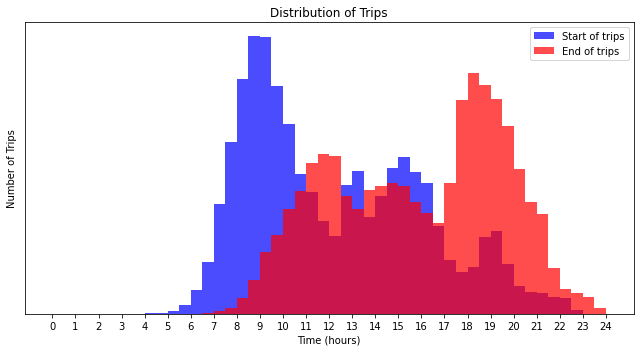

In [72]:
# Create a figure and axis with adjusted aspect ratio
fig, ax = plt.subplots(figsize=(9, 5))


# Create a histogram for DataFrame 1
ax.hist(start_times, bins=range(0, 1441, 30), color='blue', alpha=0.7, label='Start of trips')

# Create a histogram for DataFrame 2
ax.hist(end_times, bins=range(0, 1441, 30), color='red', alpha=0.7, label='End of trips')

# Set x-axis ticks and labels for each hour
ax.set_xticks(range(0, 1441, 60))
ax.set_xticklabels(range(0, 25))

# Remove y-axis tick marks
ax.set_yticks([])

# Add labels and title
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Number of Trips')
ax.set_title('Distribution of Trips')

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.savefig('data/interim/distribution_graph.png', dpi=300, facecolor='white') 
plt.show()